# Working memory example

<div class="admonition goal">
    <p class="admonition-title">Goal</p>
    <p>
        In this notebook, we reproduced the example in this <a href="https://pyro.ai/examples/working_memory.html">tutorial</a>. Since in the reference, they use <code>pyro</code>, while we use <code>numpyro</code> which do not have <code>contrib.oed</code> implemented, we implement our version and include it in the <code>probabilistic</code> module. The purpose of this notebook is to confirm that our implementation yield a similar result as the reference. 
    </p>
</div>

In [40]:
import inspeqtor.experimental as sq
import numpyro
from numpyro import handlers
from numpyro import distributions as dist
import jax
import jax.numpy as jnp

from numpyro.infer import (
    SVI,
    TraceMeanField_ELBO,
)
import optax

In [ ]:
sensitivity = 1.0
prior_mean = 7.0
prior_sd = 2.0


def make_model(mean, sd):
    def model(length):
        # Dimension -1 of `l` represents the number of rounds
        # Other dimensions are batch dimensions: we indicate this with a plate_stack
        with numpyro.plate_stack("plate", list(length.shape[:-1])):
            # Share theta across the number of rounds of the experiment
            # This represents repeatedly testing the same participant
            theta = numpyro.sample("theta", dist.Normal(mean, sd))  # type: ignore
            theta = jnp.expand_dims(theta, -1)
            # This define a *logistic regression* model for y
            logit_p = sensitivity * (theta - length)
            # The event shape represents responses from the same participant
            y = numpyro.sample("y", dist.Bernoulli(logits=logit_p).to_event(1))  # type: ignore
            return y

    return model


def guide(length: jnp.ndarray):
    # The guide is initialised at the prior
    posterior_mean = numpyro.param("posterior_mean", jnp.array(prior_mean))
    posterior_sd = numpyro.param(
        "posterior_sd", jnp.array(prior_sd), constraint=dist.constraints.positive
    )
    numpyro.sample("theta", dist.Normal(posterior_mean, posterior_sd))  # type: ignore


In [3]:
l_data = jnp.array([5., 7., 9.])
y_data = jnp.array([1., 1., 0.])

model = make_model(prior_mean, prior_sd)
conditioned_model = handlers.condition(model, {"y": y_data})

optimizer = optax.adamw(learning_rate=1e-3)

svi = SVI(
    model=conditioned_model,
    guide=guide,
    optim=numpyro.optim.optax_to_numpyro(optimizer),
    loss=TraceMeanField_ELBO(num_particles=1),
)

svi_results = svi.run(
    jax.random.key(0),
    10_000,
    l_data,
    progress_bar=True
)

100%|██████████| 10000/10000 [00:00<00:00, 10382.97it/s, init loss: 2.2569, avg. loss [9501-10000]: 1.2946]


In [4]:
svi_results.params

{'posterior_mean': Array(7.75896117, dtype=float64),
 'posterior_sd': Array(1.21964926, dtype=float64)}

In [5]:
def marginal_guide(design, observation_labels, target_labels):
    # This shape allows us to learn a different parameter for each candidate design l
    q_logit = numpyro.param("theta", jnp.zeros(design.shape[-2:]))
    numpyro.sample("y", dist.Bernoulli(logits=q_logit).to_event(1))  # type: ignore

In [ ]:
candidate_designs = jnp.arange(1, 15, dtype=jnp.float_).reshape(-1, 1)

NUM_STEP = 10_000
optimizer = sq.optimize.get_default_optimizer(NUM_STEP)

eig, aux = sq.boed.estimate_eig(
    jax.random.key(0),
    model,
    marginal_guide,
candidate_designs,  # design, or in this case, tensor of possible designs
    observation_labels=["y"],  # site label of observations, could be a list
    target_labels=[
        "theta"
    ],  # site label of 'targets' (latent variables), could also be list
    num_particles=100,  # number of samples to draw per step in the expectation
    num_optimization_steps=NUM_STEP,  # number of gradient steps
    optimizer=optimizer,  # optimizer with learning rate decay
    final_num_particles=10000,  # at the last step, we draw more samples
)

|████████████████████████████████████████| 10000/10000 [100%] in 12.8s (781.98/s


Text(0, 0.5, 'EIG($l$)')

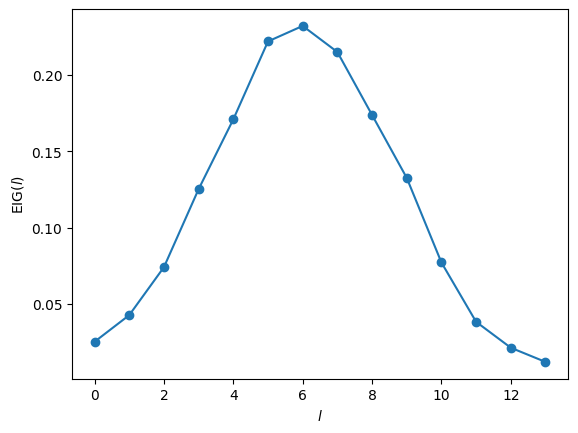

In [7]:
import matplotlib.pyplot as plt
plt.plot(eig, marker='o')
plt.xlabel("$l$")
plt.ylabel("EIG($l$)")

In [8]:
jnp.argmax(eig) + 1

Array(7, dtype=int64)

In [25]:
from flax import linen as nn

q_prob = nn.sigmoid(aux['params']['theta'])
print("   l | q(y = 1 | l)")
for (length, q) in zip(candidate_designs, q_prob):
    print("{:>4} | {}".format(int(length.item()), q.item()))

   l | q(y = 1 | l)
   1 | 0.9854291196099898
   2 | 0.9672746697025538
   3 | 0.9327353610497232
   4 | 0.8702188019632721
   5 | 0.7730606545062126
   6 | 0.650433044707223
   7 | 0.49903727648040747
   8 | 0.3516913489983096
   9 | 0.22458600618735214
  10 | 0.12840463561270873
  11 | 0.06807842543372478
  12 | 0.032421556131702306
  13 | 0.01429967846413999
  14 | 0.005834729169285767


In [11]:
def synthetic_person(length):
    # The synthetic person can remember any sequence shorter than 6
    # They cannot remember any sequence of length 6 or above
    # (There is no randomness in their responses)
    y = (length < 6).astype(jnp.float_)
    return y

In [26]:
ys = jnp.empty(shape=(1,))
ls = jnp.empty(shape=(1,))
history = [(prior_mean, prior_sd)]

current_model = make_model(prior_mean, prior_sd)

for experiment in range(10):
    print("Round", experiment + 1)

    # Step 1: compute the optimal length
    NUM_STEP = 10_000
    optimizer = sq.optimize.get_default_optimizer(NUM_STEP)

    eig, aux = sq.boed.estimate_eig(
        jax.random.key(0),
        current_model,
        marginal_guide,
        candidate_designs,  # design, or in this case, tensor of possible designs
        observation_labels=["y"],  # site label of observations, could be a list
        target_labels=[
            "theta"
        ],  # site label of 'targets' (latent variables), could also be list
        num_particles=1000,  # number of samples to draw per step in the expectation
        num_optimization_steps=NUM_STEP,  # number of gradient steps
        optimizer=optimizer,  # optimizer with learning rate decay
        final_num_particles=10000,  # at the last step, we draw more samples
    )
    best_l = jnp.argmax(eig) + 1

    # Step 2: run the experiment, here using the synthetic person
    print("Asking the participant to remember a sequence of length", int(best_l))
    y = synthetic_person(best_l)
    if y:
        print("Participant remembered correctly")
    else:
        print("Participant could not remember the sequence")
    # Store the sequence length and outcome
    ls = jnp.concat([ls, jnp.expand_dims(best_l, axis=0)], axis=0)
    ys = jnp.concat([ys, jnp.expand_dims(y, axis=0)])

    # Step 3: learn the posterior using all data seen so far
    conditioned_model = handlers.condition(model, {"y": ys})

    optimizer = sq.optimize.get_default_optimizer(NUM_STEP)
    svi = SVI(
        model=conditioned_model,
        guide=guide,
        optim=numpyro.optim.optax_to_numpyro(optimizer),
        loss=TraceMeanField_ELBO(num_particles=1),
    )

    svi_results = svi.run(jax.random.key(0), 10_000, ls, progress_bar=True)

    posterior_mean = svi_results.params["posterior_mean"]
    posterior_sd = svi_results.params["posterior_sd"]

    history.append(
        (
            posterior_mean,
            posterior_sd,
        )
    )
    current_model = make_model(
        posterior_mean,
        posterior_sd,
    )
    print("Estimate of \u03b8: {:.3f} \u00b1 {:.3f}\n".format(*history[-1]))

Round 1
|████████████████████████████████████████| 10000/10000 [100%] in 18.4s (543.98/s
Asking the participant to remember a sequence of length 7
Participant could not remember the sequence


100%|██████████| 10000/10000 [00:01<00:00, 9758.19it/s, init loss: 5.6538, avg. loss [9501-10000]: 5.1166]


Estimate of θ: 3.150 ± 1.680

Round 2
|████████████████████████████████████████| 10000/10000 [100%] in 18.2s (548.64/s
Asking the participant to remember a sequence of length 3
Participant remembered correctly


100%|██████████| 10000/10000 [00:00<00:00, 10969.01it/s, init loss: 5.7361, avg. loss [9501-10000]: 5.8018]


Estimate of θ: 4.047 ± 1.412

Round 3
|████████████████████████████████████████| 10000/10000 [100%] in 18.3s (546.00/s
Asking the participant to remember a sequence of length 4
Participant remembered correctly


100%|██████████| 10000/10000 [00:01<00:00, 9447.21it/s, init loss: 5.9457, avg. loss [9501-10000]: 6.5046]


Estimate of θ: 4.747 ± 1.231

Round 4
|████████████████████████████████████████| 10000/10000 [100%] in 18.6s (538.17/s
Asking the participant to remember a sequence of length 5
Participant remembered correctly


100%|██████████| 10000/10000 [00:00<00:00, 12438.26it/s, init loss: 6.4366, avg. loss [9501-10000]: 7.3214]


Estimate of θ: 5.376 ± 1.107

Round 5
|████████████████████████████████████████| 10000/10000 [100%] in 18.5s (542.11/s
Asking the participant to remember a sequence of length 6
Participant could not remember the sequence


100%|██████████| 10000/10000 [00:00<00:00, 10699.34it/s, init loss: 6.8943, avg. loss [9501-10000]: 7.7920]


Estimate of θ: 5.013 ± 0.990

Round 6
|████████████████████████████████████████| 10000/10000 [100%] in 18.9s (529.97/s
Asking the participant to remember a sequence of length 5
Participant remembered correctly


100%|██████████| 10000/10000 [00:00<00:00, 10993.54it/s, init loss: 7.3852, avg. loss [9501-10000]: 8.4891]


Estimate of θ: 5.404 ± 0.908

Round 7
|████████████████████████████████████████| 10000/10000 [100%] in 18.3s (546.57/s
Asking the participant to remember a sequence of length 6
Participant could not remember the sequence


100%|██████████| 10000/10000 [00:00<00:00, 10759.40it/s, init loss: 7.8429, avg. loss [9501-10000]: 8.9584]


Estimate of θ: 5.149 ± 0.839

Round 8
|████████████████████████████████████████| 10000/10000 [100%] in 18.3s (545.90/s
Asking the participant to remember a sequence of length 6
Participant could not remember the sequence


100%|██████████| 10000/10000 [00:00<00:00, 10689.39it/s, init loss: 8.3006, avg. loss [9501-10000]: 9.3473]


Estimate of θ: 4.957 ± 0.792

Round 9
|████████████████████████████████████████| 10000/10000 [100%] in 18.7s (534.44/s
Asking the participant to remember a sequence of length 5
Participant remembered correctly


100%|██████████| 10000/10000 [00:00<00:00, 10414.53it/s, init loss: 8.7915, avg. loss [9501-10000]: 10.0637]


Estimate of θ: 5.227 ± 0.737

Round 10
|████████████████████████████████████████| 10000/10000 [100%] in 18.7s (534.10/s
Asking the participant to remember a sequence of length 6
Participant could not remember the sequence


100%|██████████| 10000/10000 [00:00<00:00, 10510.62it/s, init loss: 9.2492, avg. loss [9501-10000]: 10.4691]


Estimate of θ: 5.071 ± 0.703



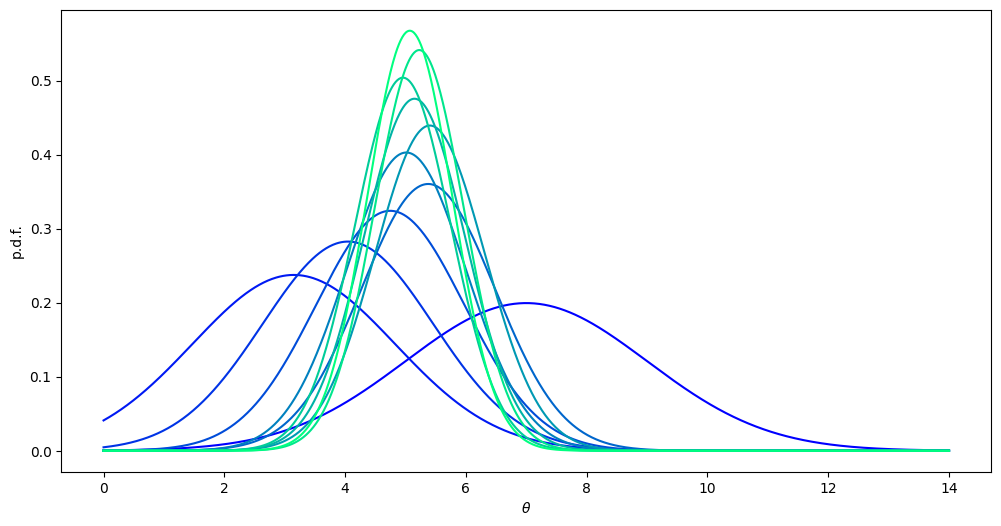

In [39]:
from jax.scipy.stats import norm
import matplotlib.colors as colors
import matplotlib.cm as cmx
import numpy as np

cmap = plt.get_cmap("winter")
cNorm = colors.Normalize(vmin=0, vmax=len(history) - 1)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cmap)
plt.figure(figsize=(12, 6))
x = jnp.linspace(0, 14, 1000)
for idx, (mean, sd) in enumerate(history):
    color = scalarMap.to_rgba(np.array(idx))
    y = norm.pdf(x, mean, sd)
    plt.plot(x, y, color=color)
    plt.xlabel("$\\theta$")
    plt.ylabel("p.d.f.")
plt.show()

In [ ]:
ls = jnp.arange(1, 11, dtype=jnp.float_)
ys = synthetic_person(ls)

conditioned_model = handlers.condition(model, {"y": ys})

optimizer = sq.optimize.get_default_optimizer(NUM_STEP)
svi = SVI(
    model=conditioned_model,
    guide=guide,
    optim=numpyro.optim.optax_to_numpyro(optimizer),
    loss=TraceMeanField_ELBO(num_particles=1),
)

svi_results = svi.run(jax.random.key(0), 10_000, ls, progress_bar=True)

100%|██████████| 10000/10000 [00:01<00:00, 9577.91it/s, init loss: 1.5913, avg. loss [9501-10000]: 2.6066]


In [37]:
svi_results.params

{'posterior_mean': Array(5.80657591, dtype=float64),
 'posterior_sd': Array(0.91837322, dtype=float64)}

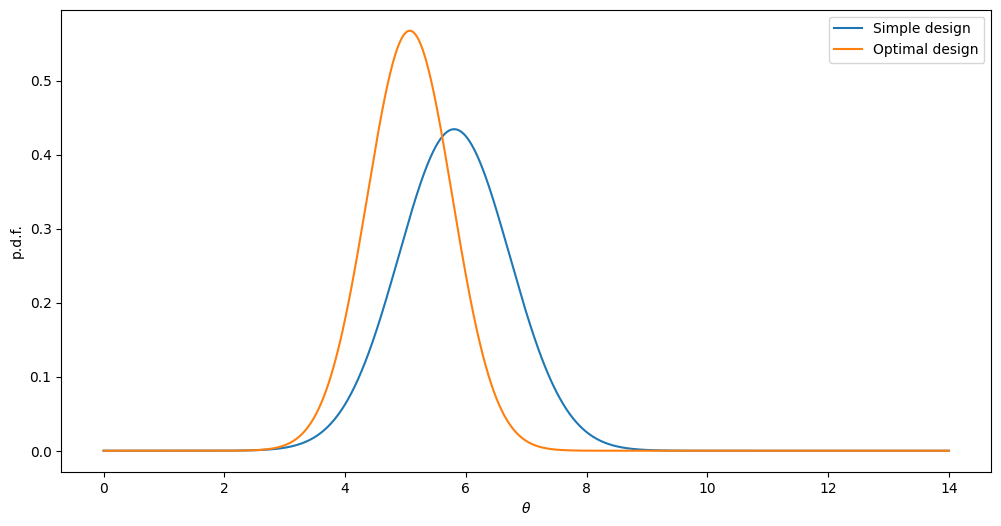

In [38]:
plt.figure(figsize=(12,6))
y1 = norm.pdf(x, svi_results.params.get("posterior_mean"),
              svi_results.params.get("posterior_sd"))
y2 = norm.pdf(x, history[-1][0], history[-1][1])
plt.plot(x, y1)
plt.plot(x, y2)
plt.legend(["Simple design", "Optimal design"])
plt.xlabel("$\\theta$")
plt.ylabel("p.d.f.")
plt.show()